In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

<b> Obtain spectrum data from FITS file </b>

In [2]:
def get_intensity_wavelength(filename):
    hdul_image_synth = fits.open(filename)

    synth_data_1 = hdul_image_synth[1].data
    wavelength_synth = synth_data_1['wavelength']
    flux_synth = synth_data_1['flux']
    normalized_flux_synth = synth_data_1['normalized flux']

    return wavelength_synth, flux_synth, normalized_flux_synth

In [3]:
filename = '../Project2/spectral_tests/M_p5500g4.0z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS'

In [4]:
wavelength_synth, flux_synth, normalized_flux_synth = get_intensity_wavelength(filename)

<b> Resolving Power (R = lambda/ delta_lambda) </b>

lambda = average wavelength
delta_lambda = FWHM

* R < 1000 (low resolution)
* 1000 < R < 50000 (intermidiate resolution)
* R > 50000 (high resolution)
* R > 500000 (very high resolution)

In [5]:
# R is assumed to be = 40000
R = 40000

<b> Average Wavelength (labmda) </b>

In [6]:
def wavelength_avg(wavelength):
    return np.mean(wavelength)

In [7]:
wv_mean = wavelength_avg(wavelength_synth)

In [8]:
wv_mean

7499.999999999999

<b> FWHM (delta lambda) - Chromatic Resolution</b>

* FWHM = 2 * sqrt(2*ln(2)) * sigma

In [9]:
def fwhm(wavelength_avg, resolvent_power):

    return wavelength_avg / resolvent_power

fwhm = fwhm(wv_mean, R)

In [10]:
fwhm

0.18749999999999997

<b> Sigma for Gaussian </b>

In [11]:
def sigma_gaussian(fwhm):
    const = 2 * np.sqrt(2*np.log(2))

    return fwhm/const

sigma = sigma_gaussian(fwhm)

In [12]:
sigma

0.07962391877700177

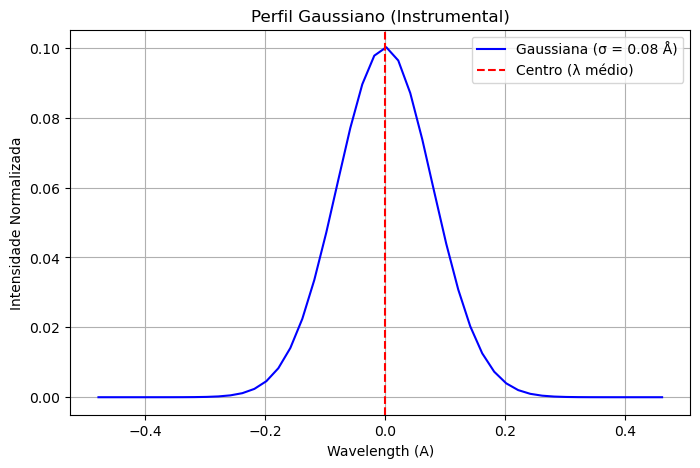

In [13]:
# Construir a gaussiana
pixel_size = wavelength_synth[1] - wavelength_synth[0]  # Supor um tamanho de pixel em Å (pequeno para alta resolução)
x = np.arange(-6 * sigma, 6 * sigma, pixel_size)  # Intervalo centrado em zero
gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)
gaussian_profile /= gaussian_profile.sum()  # Normalizar a gaussiana

# Plotar a gaussiana
plt.figure(figsize=(8, 5))
plt.plot(x, gaussian_profile, label=f"Gaussiana (σ = {sigma:.2f} Å)", color="blue")
plt.axvline(0, color="red", linestyle="--", label="Centro (λ médio)")
plt.xlabel("Wavelength (A)")
plt.ylabel("Intensidade Normalizada")
plt.title("Perfil Gaussiano (Instrumental)")
plt.legend()
plt.grid(True)
plt.show()


# Normalizing the Gaussian Profile:
# 
# A Gaussian function is defined as:
# G(x) = A * exp(-x^2 / (2 * sigma^2))
#
# Here:
# - A is the amplitude (which is adjusted during normalization).
# - sigma is the standard deviation, controlling the width of the Gaussian.
# - x is the independent variable (e.g., wavelength offset).
#
# The Gaussian is normalized to ensure that the total area under the curve is 1.
# This is important for preserving the total flux during convolution with the spectrum.
#
# For normalization:
# - The continuous integral of G(x) over all x is:
#   ∫ G(x) dx = sqrt(2 * pi * sigma^2)
# - To normalize the Gaussian, we divide by this total area.
#
# For discrete data (numerical arrays):
# 1. Compute the Gaussian: G(x) = exp(-x^2 / (2 * sigma^2))
# 2. Sum all the Gaussian values: total = sum(G(x))
# 3. Normalize: G_normalized(x) = G(x) / total
#
# In Python:
# gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)  # Compute the Gaussian
# gaussian_profile /= gaussian_profile.sum()         # Normalize to sum to 1

<b> Espetro Simulado </b>

In [14]:
# Convoluir o espectro sintético com a gaussiana
simulated_flux = convolve(flux_synth, gaussian_profile, mode='same')

In [15]:
wavelength_synth.size

450001

In [16]:
simulated_flux.size

450001

In [17]:
mask = (wavelength_synth >= 5000) & (wavelength_synth <= 6000)
wavelength_synth[mask]

array([5000.  , 5000.02, 5000.04, ..., 5999.96, 5999.98, 6000.  ],
      dtype='>f8')

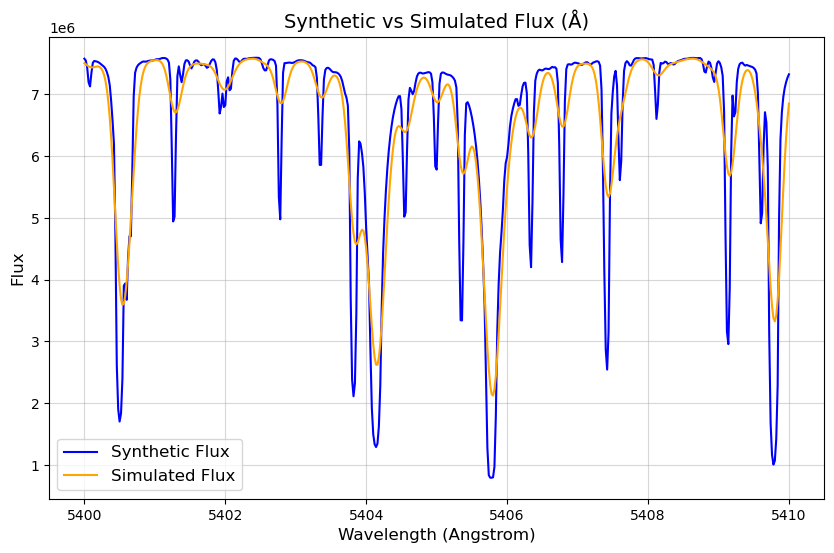

In [23]:
# Define the wavelength range
min_wavelength = 5400
max_wavelength = 5410

# Create a mask for the wavelength range
mask = (wavelength_synth >= min_wavelength) & (wavelength_synth <= max_wavelength)

# Apply the mask to select the desired range
filtered_wavelength = wavelength_synth[mask]
filtered_flux_synth = flux_synth[mask]
filtered_simulated_flux = simulated_flux[mask]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelength, filtered_flux_synth, label="Synthetic Flux", color="blue")
plt.plot(filtered_wavelength, filtered_simulated_flux, label="Simulated Flux", color="orange")

# Add labels, title, and legend
plt.xlabel("Wavelength (Angstrom)", fontsize=12)
plt.ylabel("Flux", fontsize=12)
plt.title("Synthetic vs Simulated Flux (Å)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.show()
